<a href="https://colab.research.google.com/github/medayoubaziz/Classification-predictions/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier


In [3]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/Car_Insurance_Claim.csv'
file1_path = '/content/healthcare-dataset-stroke-data.csv'
car_df = pd.read_csv(file_path)
stroke_df = pd.read_csv(file1_path)

Mounted at /content/drive


In [4]:
def explore_cat(inspection_df, x , fillna=True , placeholder='Missing' , figsize=(7,5) , order=None) :
 temp_df = inspection_df.copy()
 null_count = temp_df[x].isna().sum()
 null_per = null_count * 100 / len(temp_df)
 if fillna == True :
  temp_df[x].fillna(placeholder , inplace = True)
 fig,ax = plt.subplots(figsize=figsize)
 sns.countplot(data=temp_df , x=x , ax=ax , order=order)
 ax.set_xticklabels(ax.get_xticklabels(), fontsize = 12 , rotation = 45 , ha = 'right')
 ax.set_title(f'column : {x}' , fontweight = 'bold' , fontsize = 15)
 sns.despine()
 fig.tight_layout()
 plt.show()
 print(f'There is {null_count} NaN ({round(null_per,2)}%)')
 nunique = temp_df[x].nunique()
 print(f'There is {nunique} unique values')
 most_common_value = temp_df[x].value_counts(dropna=False).index[0]
 freq = temp_df[x].value_counts(dropna=False).values[0]
 per_common_value = freq * 100 / len(temp_df)
 print(f'The most common value is {most_common_value} , occurs {freq} times ({round(per_common_value,2)}%)')
 if per_common_value > 98 :
  print(f'{x}: is a constant or quasi-constant feature and should be dropped')
 else :
  print(f'{x}: is neither constant or a quasi-constant feauture and should be kept')
 return fig,ax

def plot_cat_vs_target(inspection_df , x , y='rating' , placeholder='Missing' , order=None , figsize=(7,5) , fillna = True):
 temp_df = inspection_df.copy()
 if fillna == True:
  temp_df[x].fillna(placeholder, inplace=True)
 else:
  temp_df = temp_df.dropna(subset=[x])
 fig,ax = plt.subplots(figsize=figsize)
 sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6, linewidth=1, edgecolor='black', errorbar=None)
 sns.stripplot(data=temp_df, x=x , y=y , hue=x , ax=ax , order=order, hue_order=order, legend=False , edgecolor='white', linewidth=0.5,
 size=3,zorder=0)
 ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right' , fontsize = 12)
 ax.set_title(f"{x} vs. {y}", fontweight='bold' , fontsize=15)
 fig.tight_layout()
 plt.show()
 return fig, ax


In [5]:
def explore_num(inspection_df , x , figsize=(7.5)) :
 temp_df = inspection_df.copy()
 null_count = temp_df[x].isna().sum()
 null_per = null_count * 100 / len(temp_df)
 nunique = temp_df[x].nunique()
 most_common_value = temp_df[x].value_counts(dropna=False).index[0]
 freq = temp_df[x].value_counts(dropna=False).values[0]
 per_common_value = freq * 100 / len(temp_df)
 gridspec = {'height_ratios':[0.7,0.3]}
 fig,ax = plt.subplots(nrows=2 , figsize=figsize , sharex=True , gridspec_kw=gridspec)
 sns.histplot(data=temp_df , x=x , ax= ax[0])
 sns.boxplot(data=temp_df , x=x , ax=ax[1])
 ax[0].set_title(f"Column: {x}", fontweight='bold' , fontsize = 15)
 sns.despine()
 fig.tight_layout()
 plt.show()
 print(f'There is {null_count} NaN ({round(null_per,2)}%)')
 print(f'There is {nunique} unique values')
 print(f'The most common value is {most_common_value} , occurs {freq} times ({round(per_common_value,2)}%)')
 if per_common_value > 98 :
  print(f'{x}: is a constant or quasi-constant feature and should be dropped')
 else :
  print(f'{x}: is neither constant or a quasi-constant feauture and should be kept')
 return fig,ax

def plot_num_vs_target(inspection_df ,x,y='rating' , figsize=(7,5)):
  temp_df = inspection_df.copy()
  corr = temp_df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.7}
  sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')
  fig.tight_layout()
  plt.show()
  return fig, ax


In [6]:
car_df.info()
car_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0

#1. Source of data

https://www.kaggle.com/

#2. Brief description of data

The data has 19 features from there 18 of them are corresponding logs which were taken by the company  to find out the real customer behaviors .

#3. What is the target?

Our target is the column : OUTCOME.

#4. What does one row represent? (A person? A business? An event? A product?)

Each row represent a patient with a potential stroke.

#5. Is this a classification or regression problem?

This is a classification problem .

#6. How many features does the data have?

There is 18 feautres except our target .

#7. How many rows are in the dataset?

1000 rows .

#8. What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?

I'm going to check for duplicated rows and the null values/missing data and explore them and then i'm going to check the balance of our target so it can help me with my model.

In [7]:
car_df.duplicated().sum()

0

In [8]:
car_df.isna().sum()

ID                       0
AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

<Axes: >

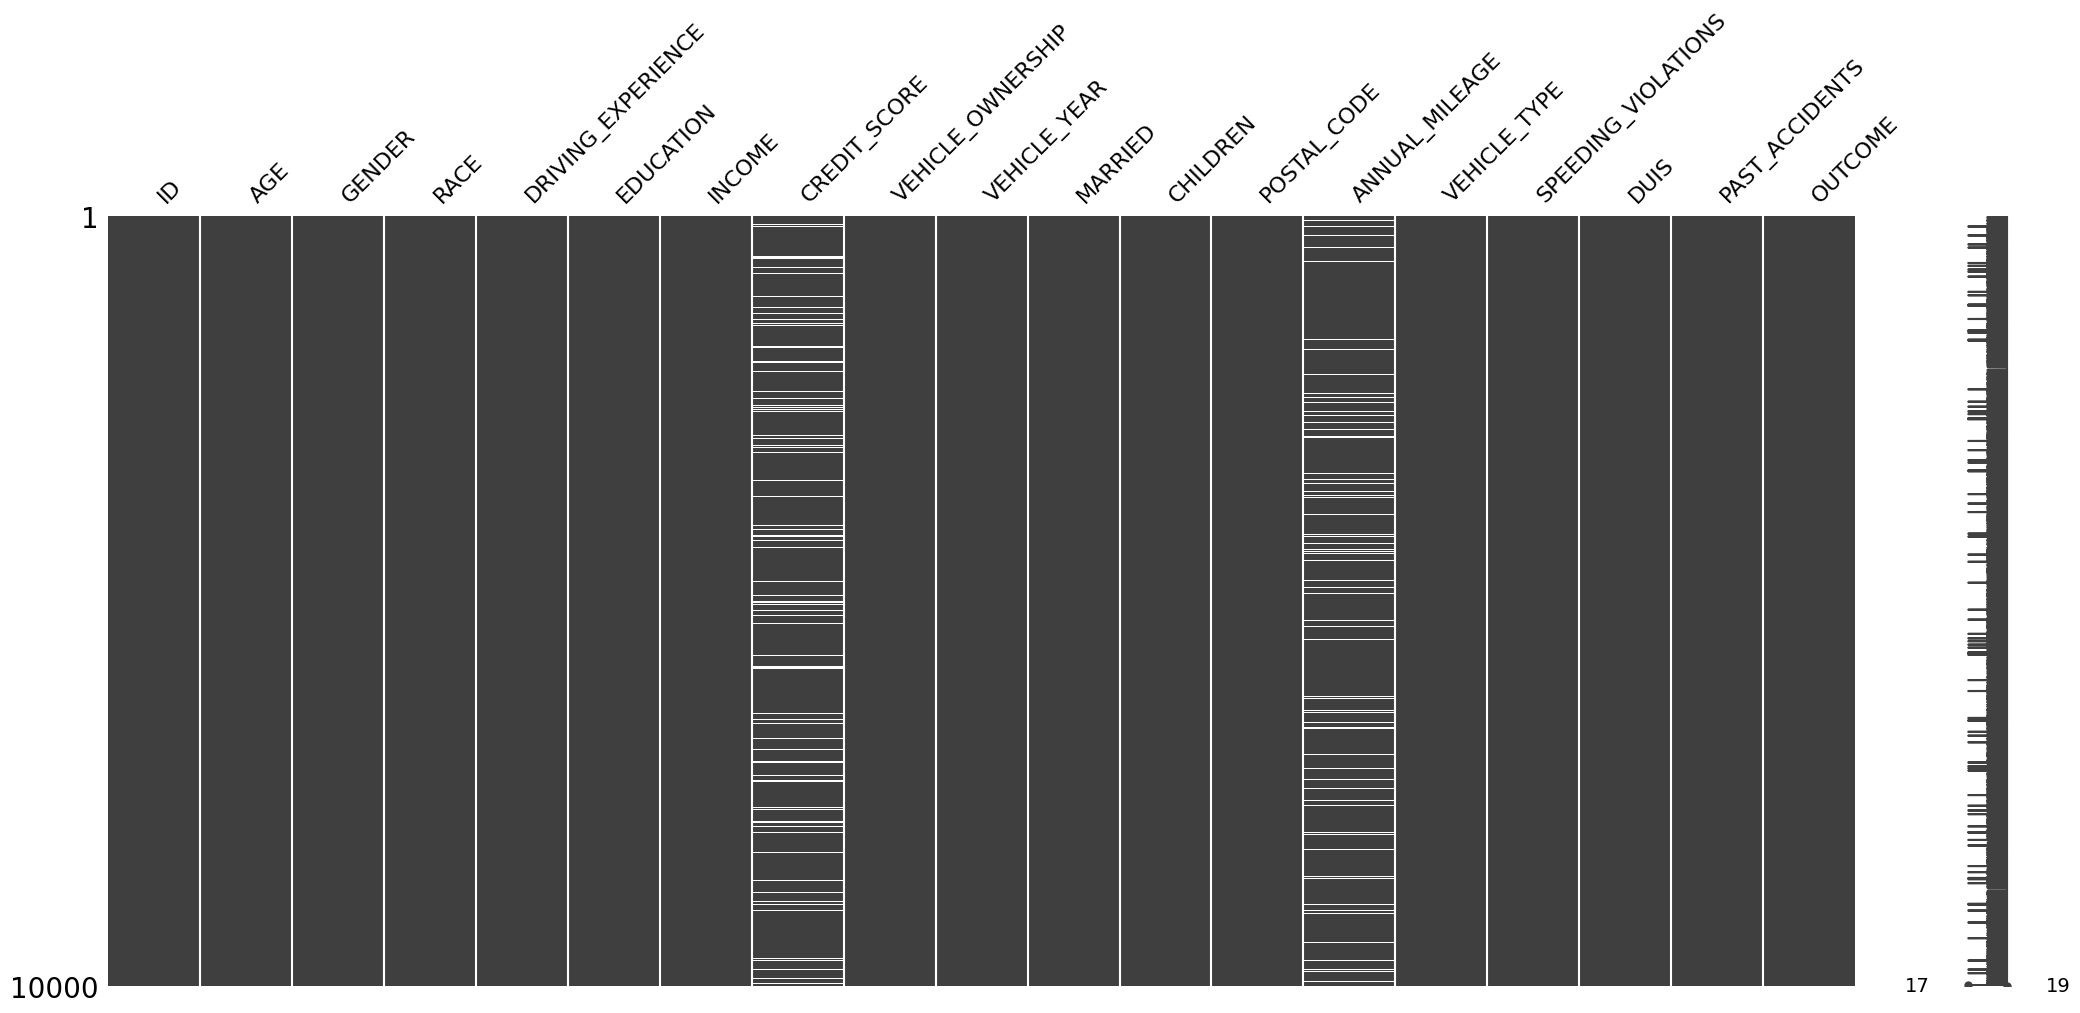

In [9]:
import missingno as msno
msno.matrix(car_df)

As we can see , there are two features with missing data : CREDIT_SCORE and ANNUAL_MILEAGE , the other features and the target dosen't have missig values .

In [10]:
car_df['ID'].value_counts().sum()/len(car_df)

1.0

In [11]:
#let's change the index of our data
car_df = car_df.set_index('ID')
car_df.head()

AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
ID                                                                
569520    65+  female  majority               0-9y  high school   
750365  16-25    male  majority               0-9y         none   
199901  16-25  female  majority               0-9y  high school   
478866  16-25    male  majority               0-9y   university   
731664  26-39    male  majority             10-19y         none   

               INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
ID                                                                             
569520    upper class      0.629027                1.0   after 2015      0.0   
750365        poverty      0.357757                0.0  before 2015      0.0   
199901  working class      0.493146                1.0  before 2015      0.0   
478866  working class      0.206013                1.0  before 2015      0.0   
731664  working class      0.388366                1.0  before 2015      0.0   

        CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  \
ID                                                           
569520       1.0        10238         12000.0        sedan   
750365       0.0        10238         16000.0        sedan   
199901       0.0        10238         11000.0        sedan   
478866       1.0        32765         11000.0        sedan   
731664       0.0        32765         12000.0        sedan   

        SPEEDING_VIOLATIONS  DUIS  PAST_ACCIDENTS  OUTCOME  
ID                                                          
569520                    0     0               0      0.0  
750365                    0     0               0      1.0  
199901                    0     0               0      0.0  
478866                    0     0               0      0.0  
731664                    2     0               1      1.0

In [12]:
 car_df.select_dtypes('number').columns


Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS', 'OUTCOME'],
      dtype='object')

##Target column

In [13]:
car_df['OUTCOME'].value_counts(normalize=True)

0.0    0.6867
1.0    0.3133
Name: OUTCOME, dtype: float64

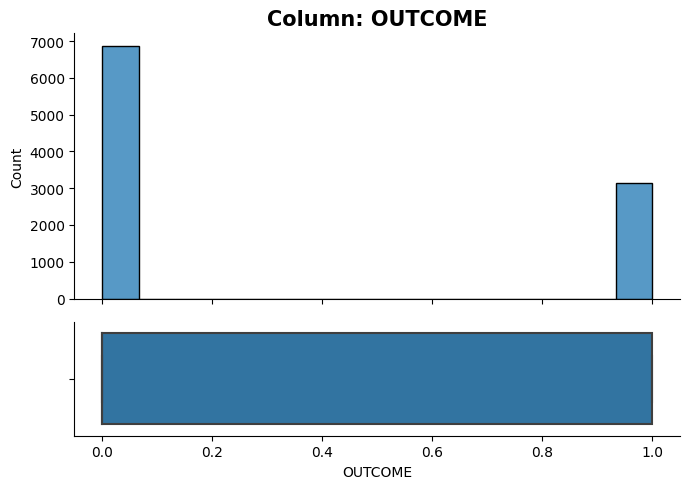

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is 0.0 , occurs 6867 times (68.67%)
OUTCOME: is neither constant or a quasi-constant feauture and should be kept


In [14]:
explore_num(car_df,'OUTCOME',figsize=(7,5));

##CREDIT_SCORE column

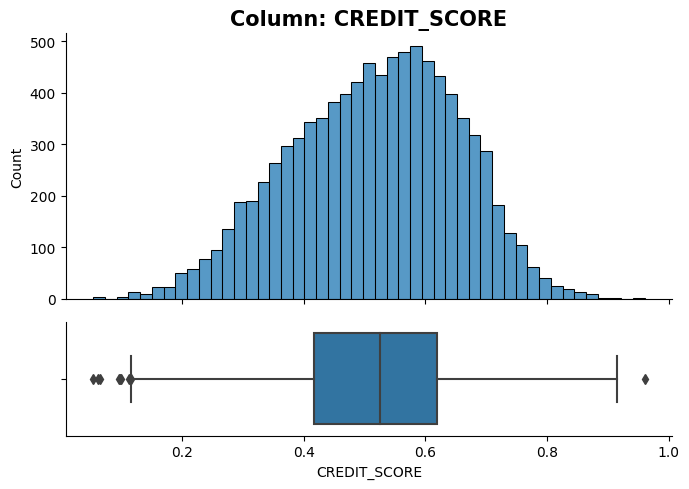

There is 982 NaN (9.82%)
There is 9018 unique values
The most common value is nan , occurs 982 times (9.82%)
CREDIT_SCORE: is neither constant or a quasi-constant feauture and should be kept


In [15]:
explore_num(car_df,'CREDIT_SCORE',figsize=(7,5));

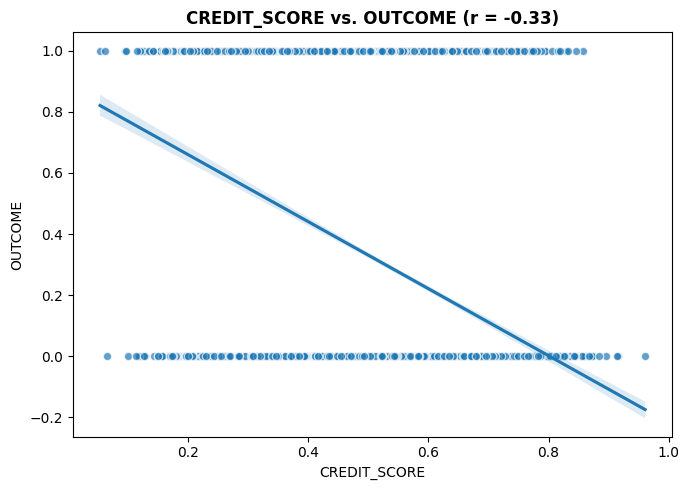

In [16]:
target = 'OUTCOME'
plot_num_vs_target(car_df,x='CREDIT_SCORE',y=target);

CREDIT_SCORE is a numerical feature with 9.82% of missing values , for the imputation i'm going to use median as a strategy.

##VEHICLE_OWNERSHIP column

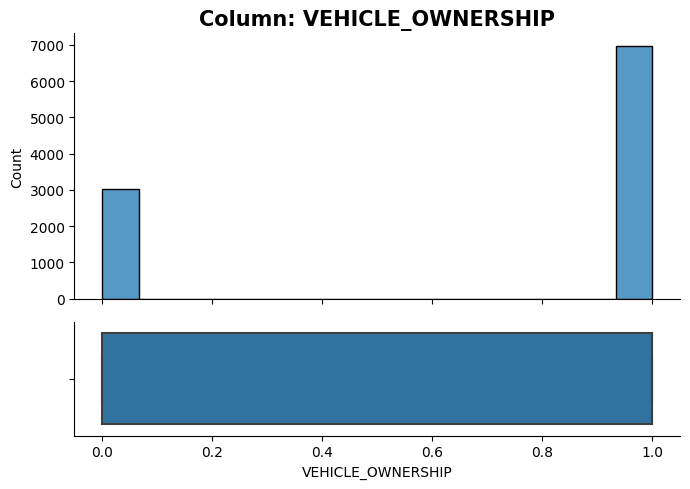

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is 1.0 , occurs 6970 times (69.7%)
VEHICLE_OWNERSHIP: is neither constant or a quasi-constant feauture and should be kept


In [17]:
explore_num(car_df,'VEHICLE_OWNERSHIP',figsize=(7,5));

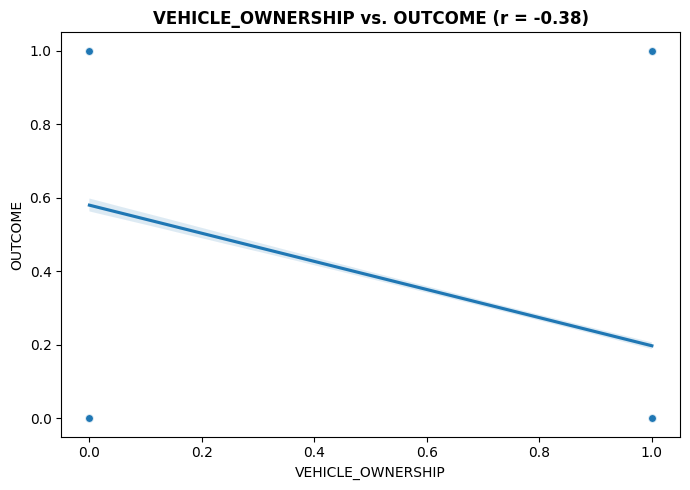

In [18]:
plot_num_vs_target(car_df,'VEHICLE_OWNERSHIP',y=target);

##MARRIED column

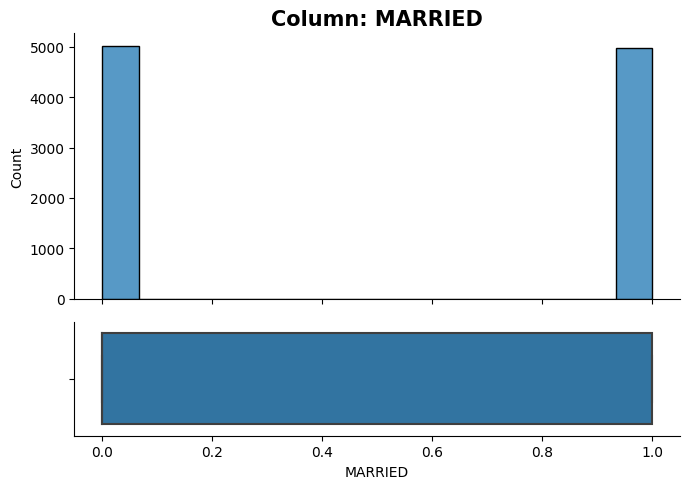

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is 0.0 , occurs 5018 times (50.18%)
MARRIED: is neither constant or a quasi-constant feauture and should be kept


In [19]:
explore_num(car_df,'MARRIED',figsize=(7,5));

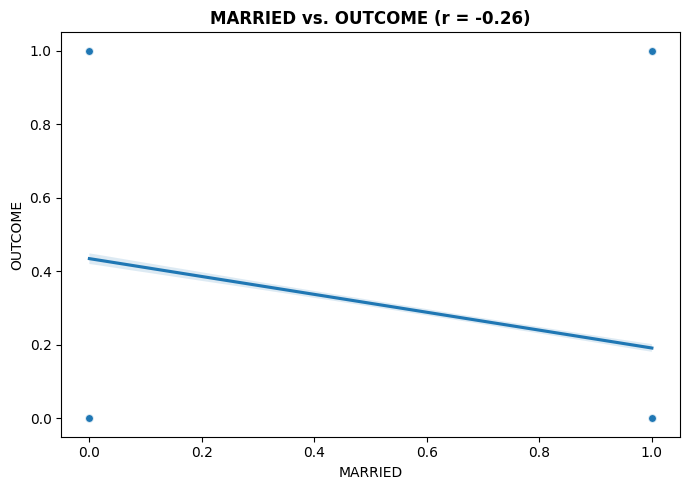

In [20]:
plot_num_vs_target(car_df,'MARRIED',y=target);

##CHILDREN column

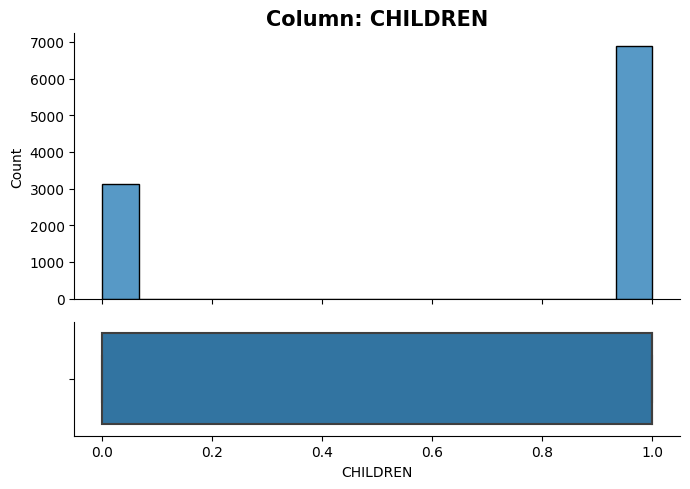

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is 1.0 , occurs 6888 times (68.88%)
CHILDREN: is neither constant or a quasi-constant feauture and should be kept


In [21]:
explore_num(car_df,'CHILDREN',figsize=(7,5));

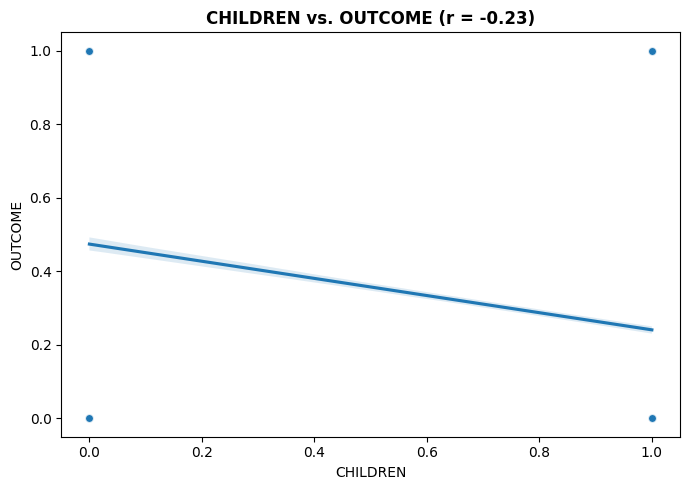

In [22]:
plot_num_vs_target(car_df,'CHILDREN',y=target);

##POSTAL_CODE column

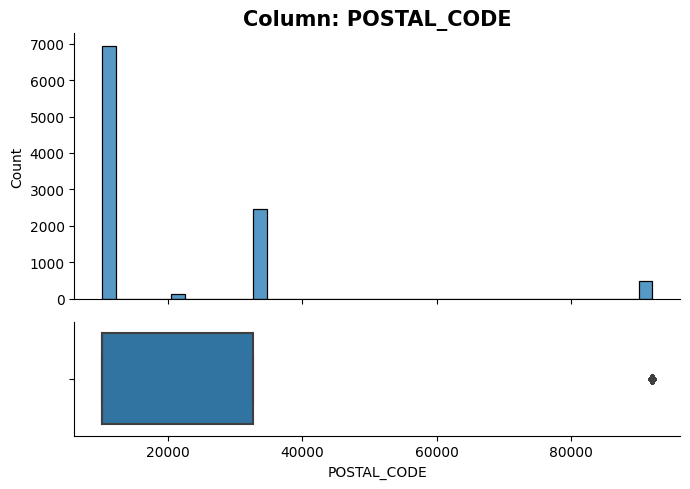

There is 0 NaN (0.0%)
There is 4 unique values
The most common value is 10238 , occurs 6940 times (69.4%)
POSTAL_CODE: is neither constant or a quasi-constant feauture and should be kept


In [23]:
explore_num(car_df,'POSTAL_CODE',figsize=(7,5));

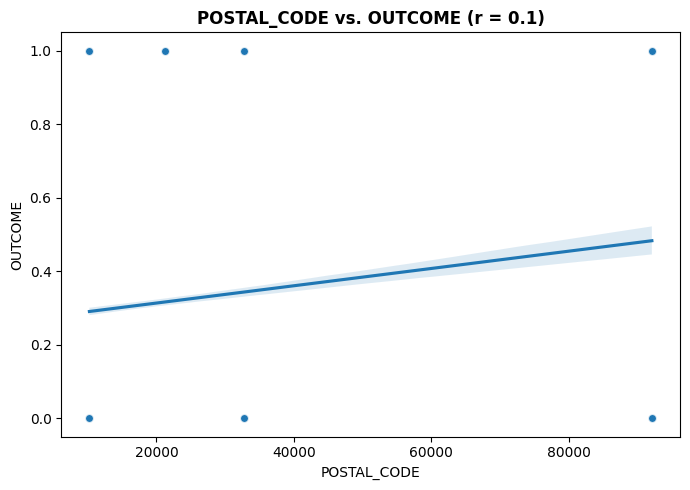

In [24]:
plot_num_vs_target(car_df,'POSTAL_CODE',y=target);

##ANNUAL_MILEAGE column

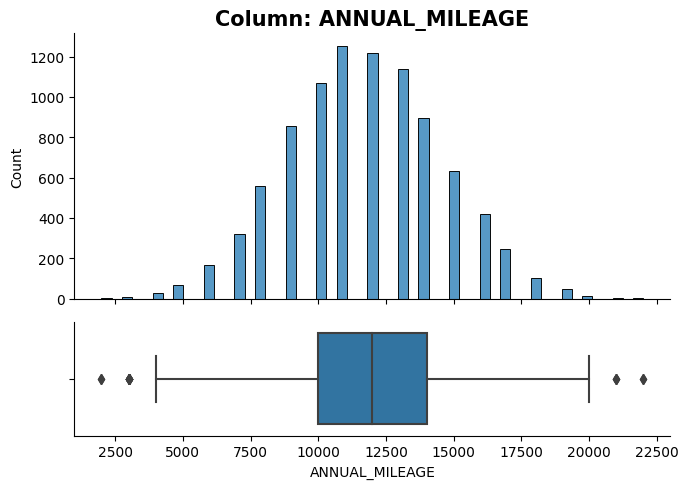

There is 957 NaN (9.57%)
There is 21 unique values
The most common value is 11000.0 , occurs 1253 times (12.53%)
ANNUAL_MILEAGE: is neither constant or a quasi-constant feauture and should be kept


In [25]:
explore_num(car_df,'ANNUAL_MILEAGE',figsize=(7,5));

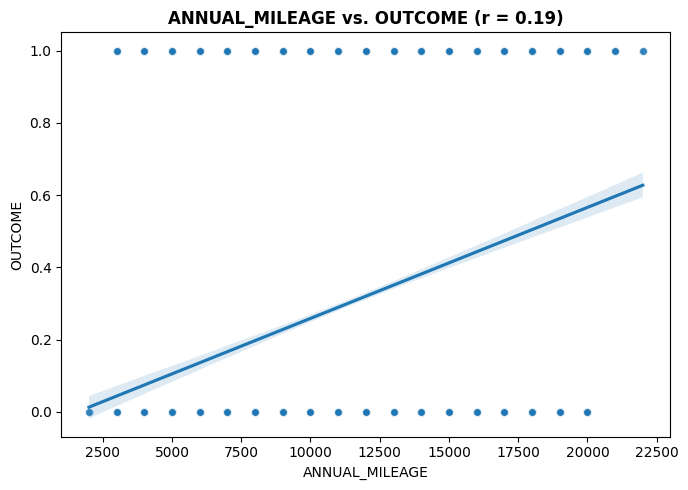

In [26]:
plot_num_vs_target(car_df,'ANNUAL_MILEAGE',y=target);

The ANNUAL_MILEAGE column is a numerical feature with 9.57% of missing values so i'm going to impute with the median as a strategy.

##SPEEDING_VIOLATIONS column

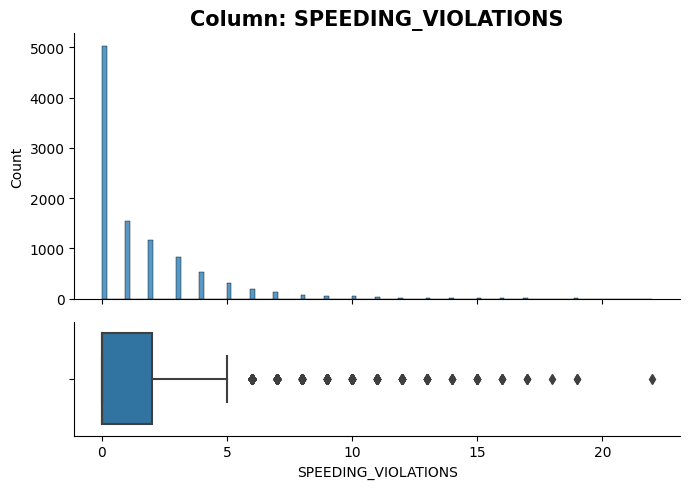

There is 0 NaN (0.0%)
There is 21 unique values
The most common value is 0 , occurs 5028 times (50.28%)
SPEEDING_VIOLATIONS: is neither constant or a quasi-constant feauture and should be kept


In [27]:
explore_num(car_df,'SPEEDING_VIOLATIONS',figsize=(7,5));

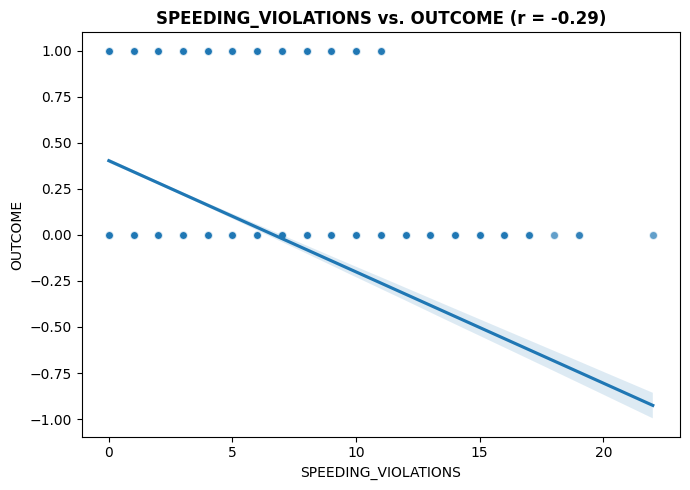

In [28]:
plot_num_vs_target(car_df,'SPEEDING_VIOLATIONS',y=target);

##DUIS column

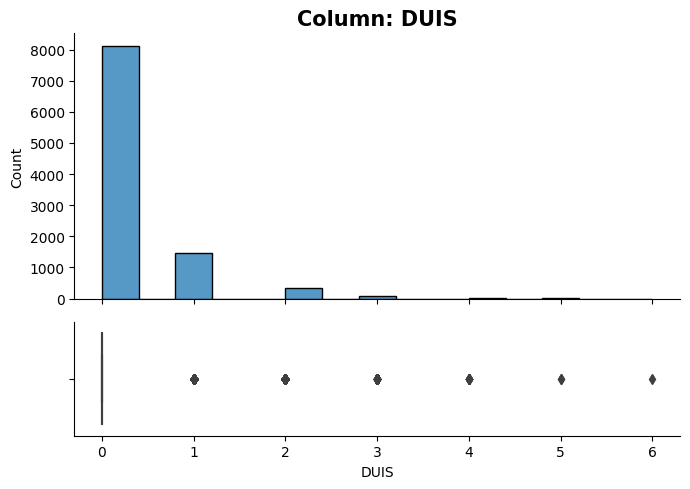

There is 0 NaN (0.0%)
There is 7 unique values
The most common value is 0 , occurs 8118 times (81.18%)
DUIS: is neither constant or a quasi-constant feauture and should be kept


In [29]:
explore_num(car_df,'DUIS',figsize=(7,5));

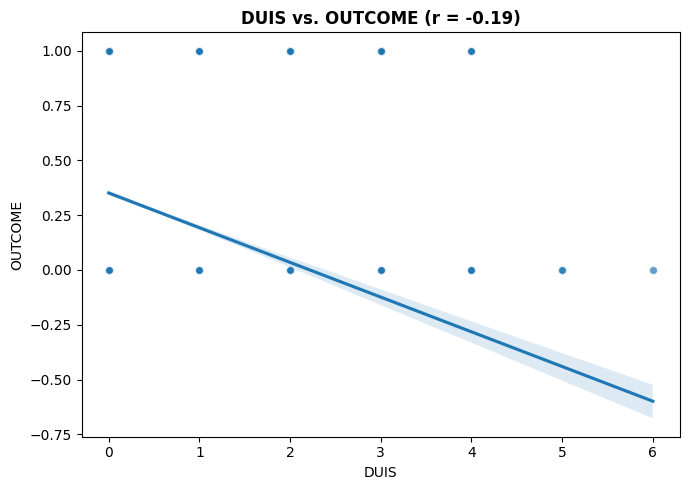

In [30]:
plot_num_vs_target(car_df,'DUIS',y=target);

##PAST_ACCIDENTS column

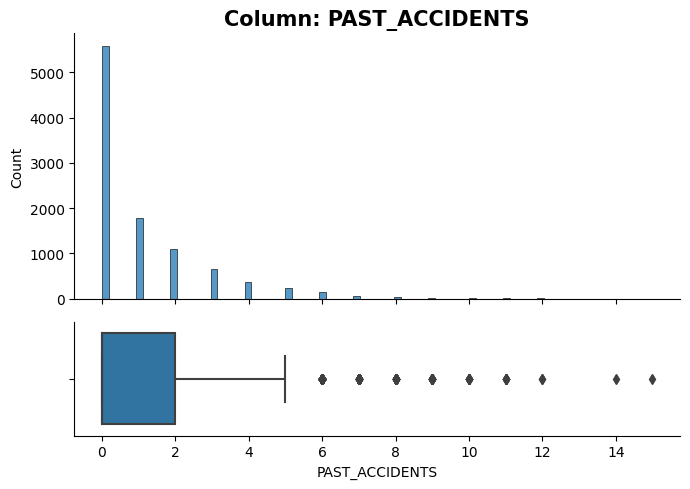

There is 0 NaN (0.0%)
There is 15 unique values
The most common value is 0 , occurs 5584 times (55.84%)
PAST_ACCIDENTS: is neither constant or a quasi-constant feauture and should be kept


In [31]:
explore_num(car_df,'PAST_ACCIDENTS',figsize=(7,5));

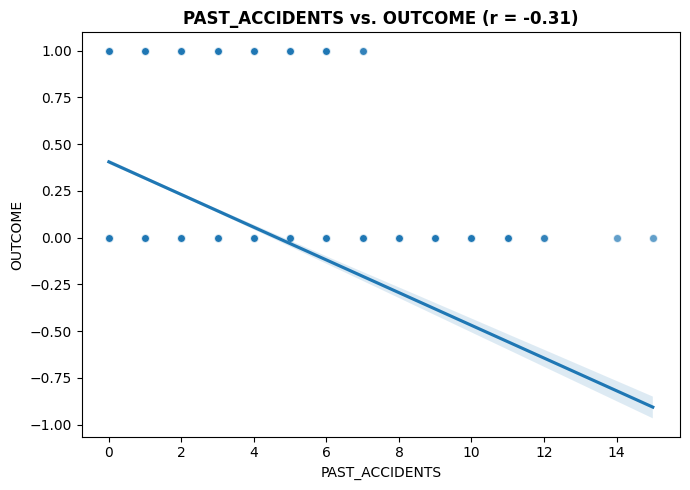

In [32]:
plot_num_vs_target(car_df,'PAST_ACCIDENTS',y=target);

<ipython-input-33-3c04c146524d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = car_df.corr()


<Axes: >

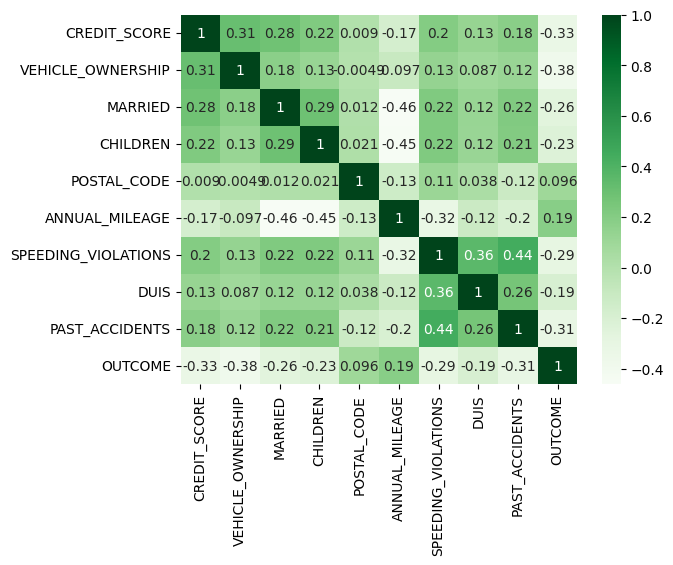

In [33]:
corr = car_df.corr()
sns.heatmap(corr, cmap = 'Greens' , annot=True)


In [34]:
car_df.describe().round(2)

CREDIT_SCORE  VEHICLE_OWNERSHIP  MARRIED  CHILDREN  POSTAL_CODE  \
count       9018.00           10000.00  10000.0  10000.00     10000.00   
mean           0.52               0.70      0.5      0.69     19864.55   
std            0.14               0.46      0.5      0.46     18915.61   
min            0.05               0.00      0.0      0.00     10238.00   
25%            0.42               0.00      0.0      0.00     10238.00   
50%            0.53               1.00      0.0      1.00     10238.00   
75%            0.62               1.00      1.0      1.00     32765.00   
max            0.96               1.00      1.0      1.00     92101.00   

       ANNUAL_MILEAGE  SPEEDING_VIOLATIONS      DUIS  PAST_ACCIDENTS   OUTCOME  
count         9043.00             10000.00  10000.00        10000.00  10000.00  
mean         11697.00                 1.48      0.24            1.06      0.31  
std           2818.43                 2.24      0.55            1.65      0.46  
min           2000.00                 0.00      0.00            0.00      0.00  
25%          10000.00                 0.00      0.00            0.00      0.00  
50%          12000.00                 0.00      0.00            0.00      0.00  
75%          14000.00                 2.00      0.00            2.00      1.00  
max          22000.00                22.00      6.00           15.00      1.00

In [35]:
car_df.select_dtypes('object').columns

Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'VEHICLE_YEAR', 'VEHICLE_TYPE'],
      dtype='object')

##AGE column

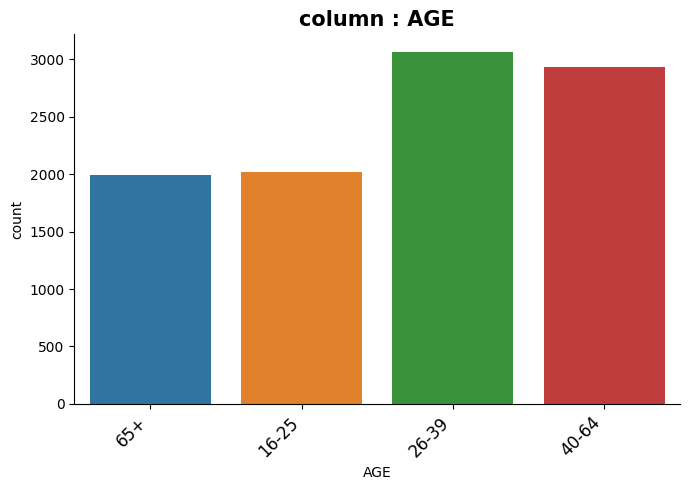

There is 0 NaN (0.0%)
There is 4 unique values
The most common value is 26-39 , occurs 3063 times (30.63%)
AGE: is neither constant or a quasi-constant feauture and should be kept


In [36]:
explore_cat(car_df,'AGE');

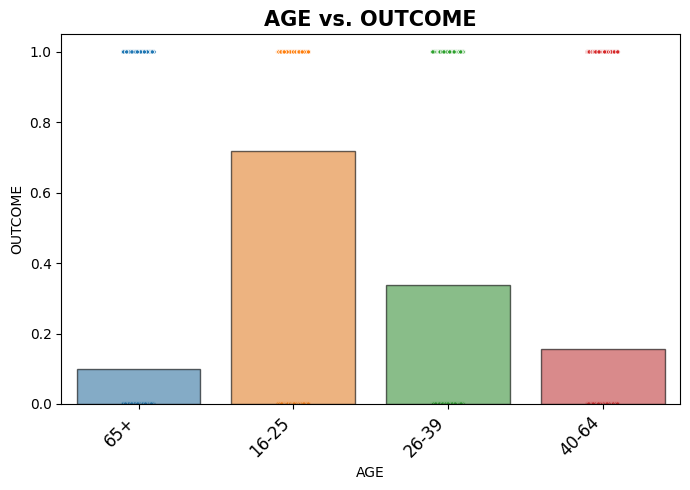

In [37]:
plot_cat_vs_target(car_df,'AGE',y=target);

##GENDER column

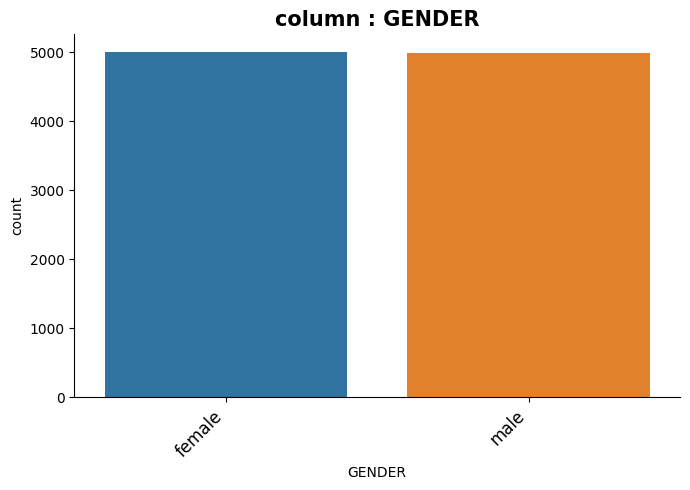

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is female , occurs 5010 times (50.1%)
GENDER: is neither constant or a quasi-constant feauture and should be kept


In [38]:
explore_cat(car_df,'GENDER');

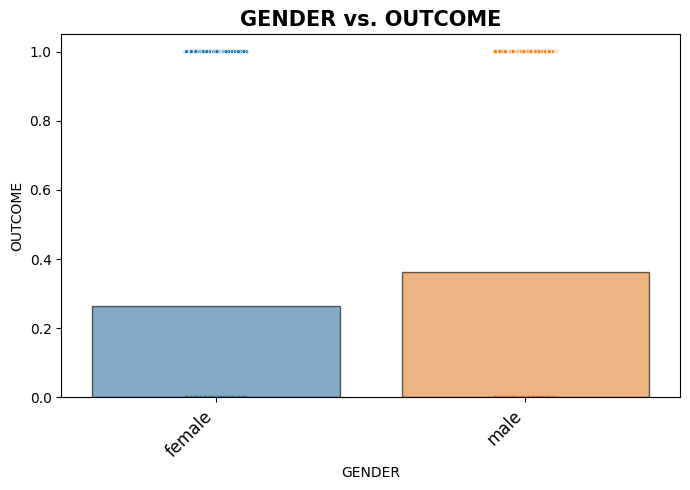

In [39]:
plot_cat_vs_target(car_df,'GENDER',y=target);

##RACE column

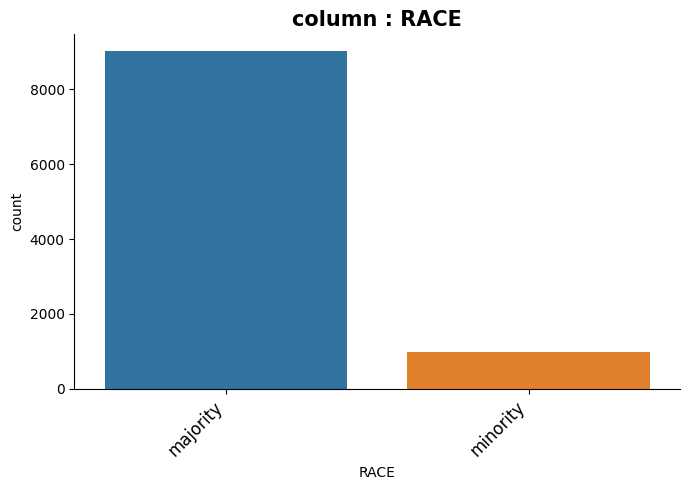

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is majority , occurs 9012 times (90.12%)
RACE: is neither constant or a quasi-constant feauture and should be kept


In [40]:
explore_cat(car_df,'RACE');

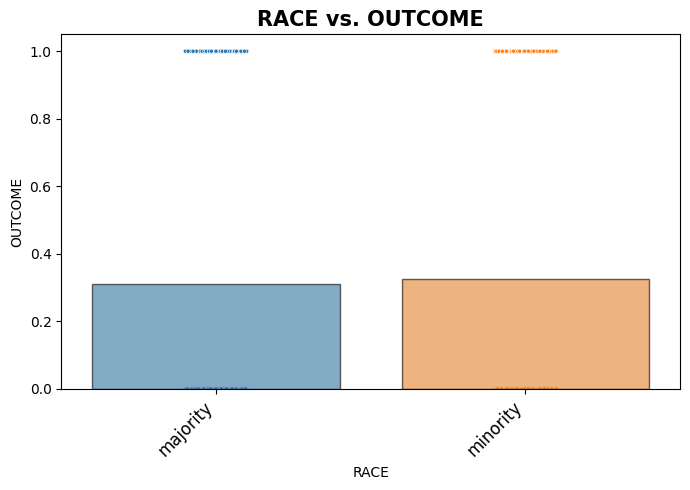

In [41]:
plot_cat_vs_target(car_df,'RACE',y=target);

##DRIVING_EXPERIENCE column

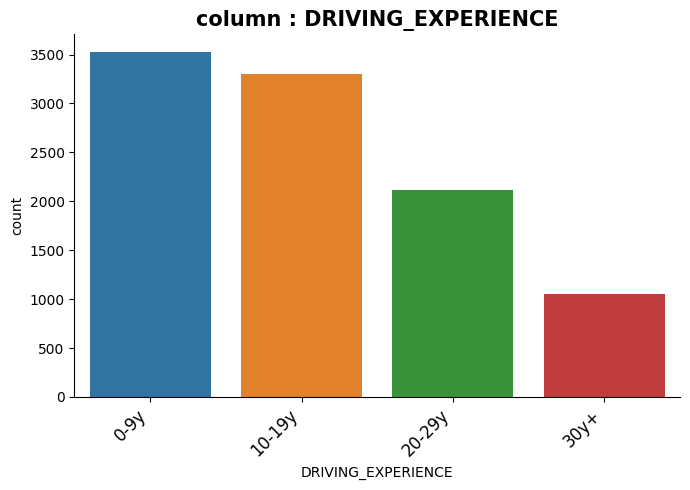

There is 0 NaN (0.0%)
There is 4 unique values
The most common value is 0-9y , occurs 3530 times (35.3%)
DRIVING_EXPERIENCE: is neither constant or a quasi-constant feauture and should be kept


In [42]:
explore_cat(car_df,'DRIVING_EXPERIENCE');

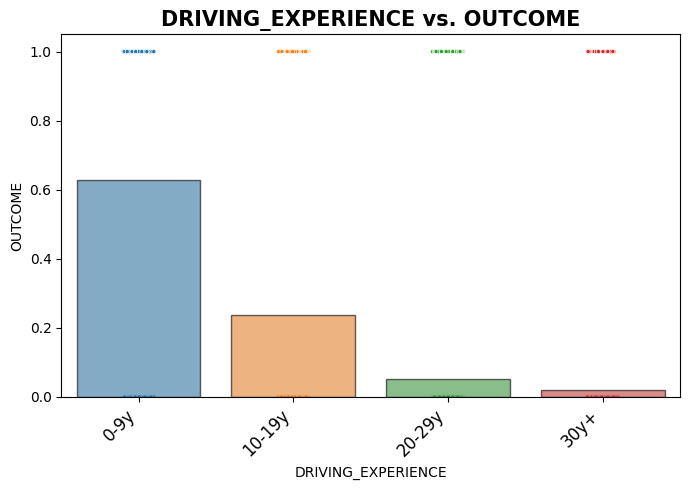

In [43]:
plot_cat_vs_target(car_df,'DRIVING_EXPERIENCE',y=target);

##EDUCATION column

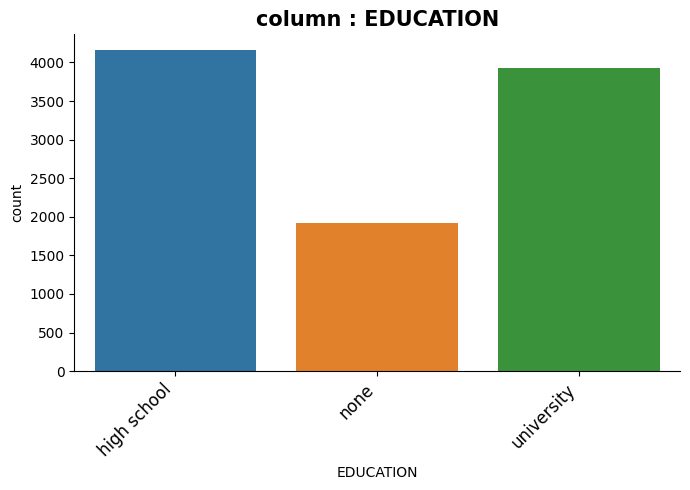

There is 0 NaN (0.0%)
There is 3 unique values
The most common value is high school , occurs 4157 times (41.57%)
EDUCATION: is neither constant or a quasi-constant feauture and should be kept


In [44]:
explore_cat(car_df,'EDUCATION');

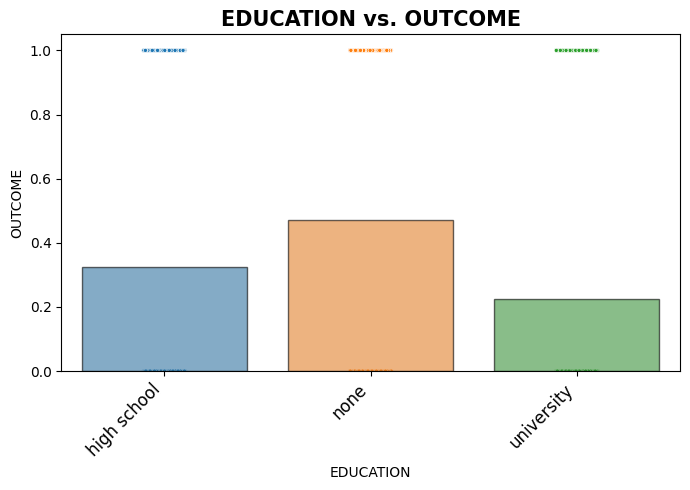

In [45]:
plot_cat_vs_target(car_df,'EDUCATION',y=target);

##INCOME column

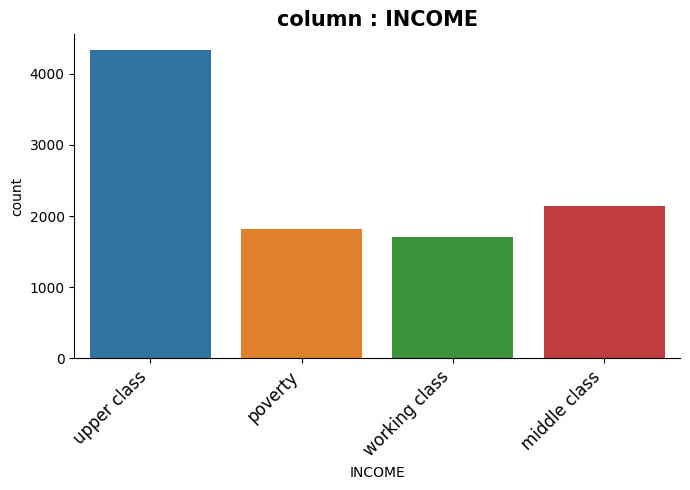

There is 0 NaN (0.0%)
There is 4 unique values
The most common value is upper class , occurs 4336 times (43.36%)
INCOME: is neither constant or a quasi-constant feauture and should be kept


In [46]:
explore_cat(car_df,'INCOME');

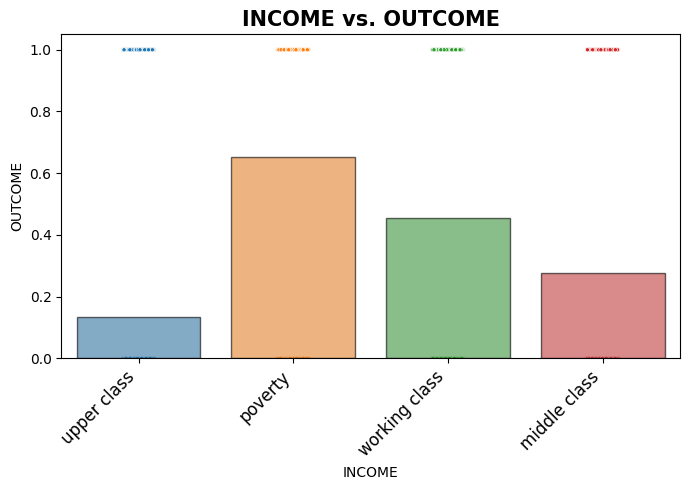

In [47]:
plot_cat_vs_target(car_df,'INCOME',y=target);

##VEHICLE_YEAR column

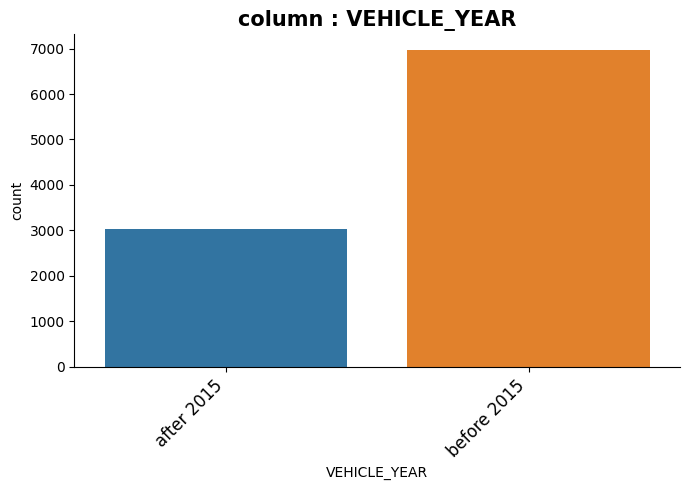

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is before 2015 , occurs 6967 times (69.67%)
VEHICLE_YEAR: is neither constant or a quasi-constant feauture and should be kept


In [48]:
explore_cat(car_df,'VEHICLE_YEAR');

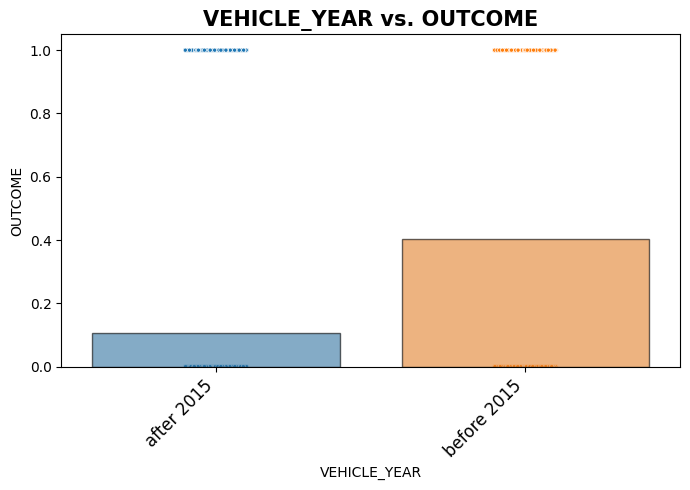

In [49]:
plot_cat_vs_target(car_df,'VEHICLE_YEAR',y=target);

##VEHICLE_TYPE column

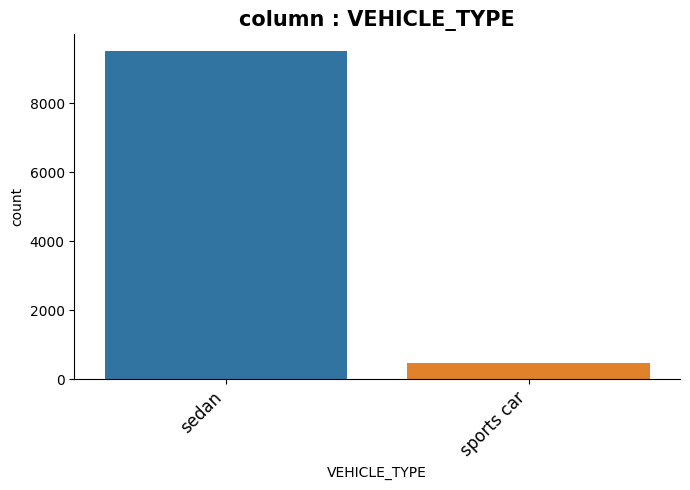

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is sedan , occurs 9523 times (95.23%)
VEHICLE_TYPE: is neither constant or a quasi-constant feauture and should be kept


In [50]:
explore_cat(car_df,'VEHICLE_TYPE');

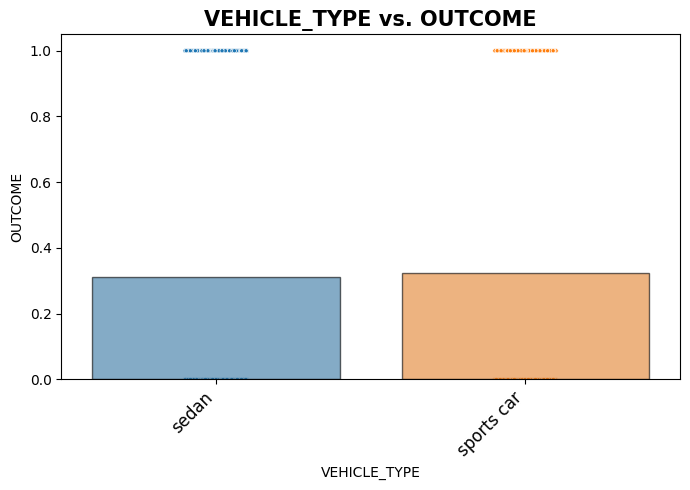

In [51]:
plot_cat_vs_target(car_df,'VEHICLE_TYPE',y=target);

#Stroke Data

In [52]:
stroke_df.info()
stroke_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

#1. Source of data

https://www.kaggle.com/

#2. Brief description of data

This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

#3. What is the target?

Our target is the column : stroke.

#4. What does one row represent? (A person? A business? An event? A product?)

Each row represent a person with a car .

#5. Is this a classification or regression problem?

Classification problem.

#6. How many features does the data have?

11 feautres and our target .

#7. How many rows are in the dataset?

5110 rows .

#8. What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?

I'm going to check for duplicated rows and the null values/missing data and explore them and then i'm going to check the balance of our target so it can help me with my model.

In [53]:
stroke_df.duplicated().sum()

0

In [54]:
stroke_df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

<Axes: >

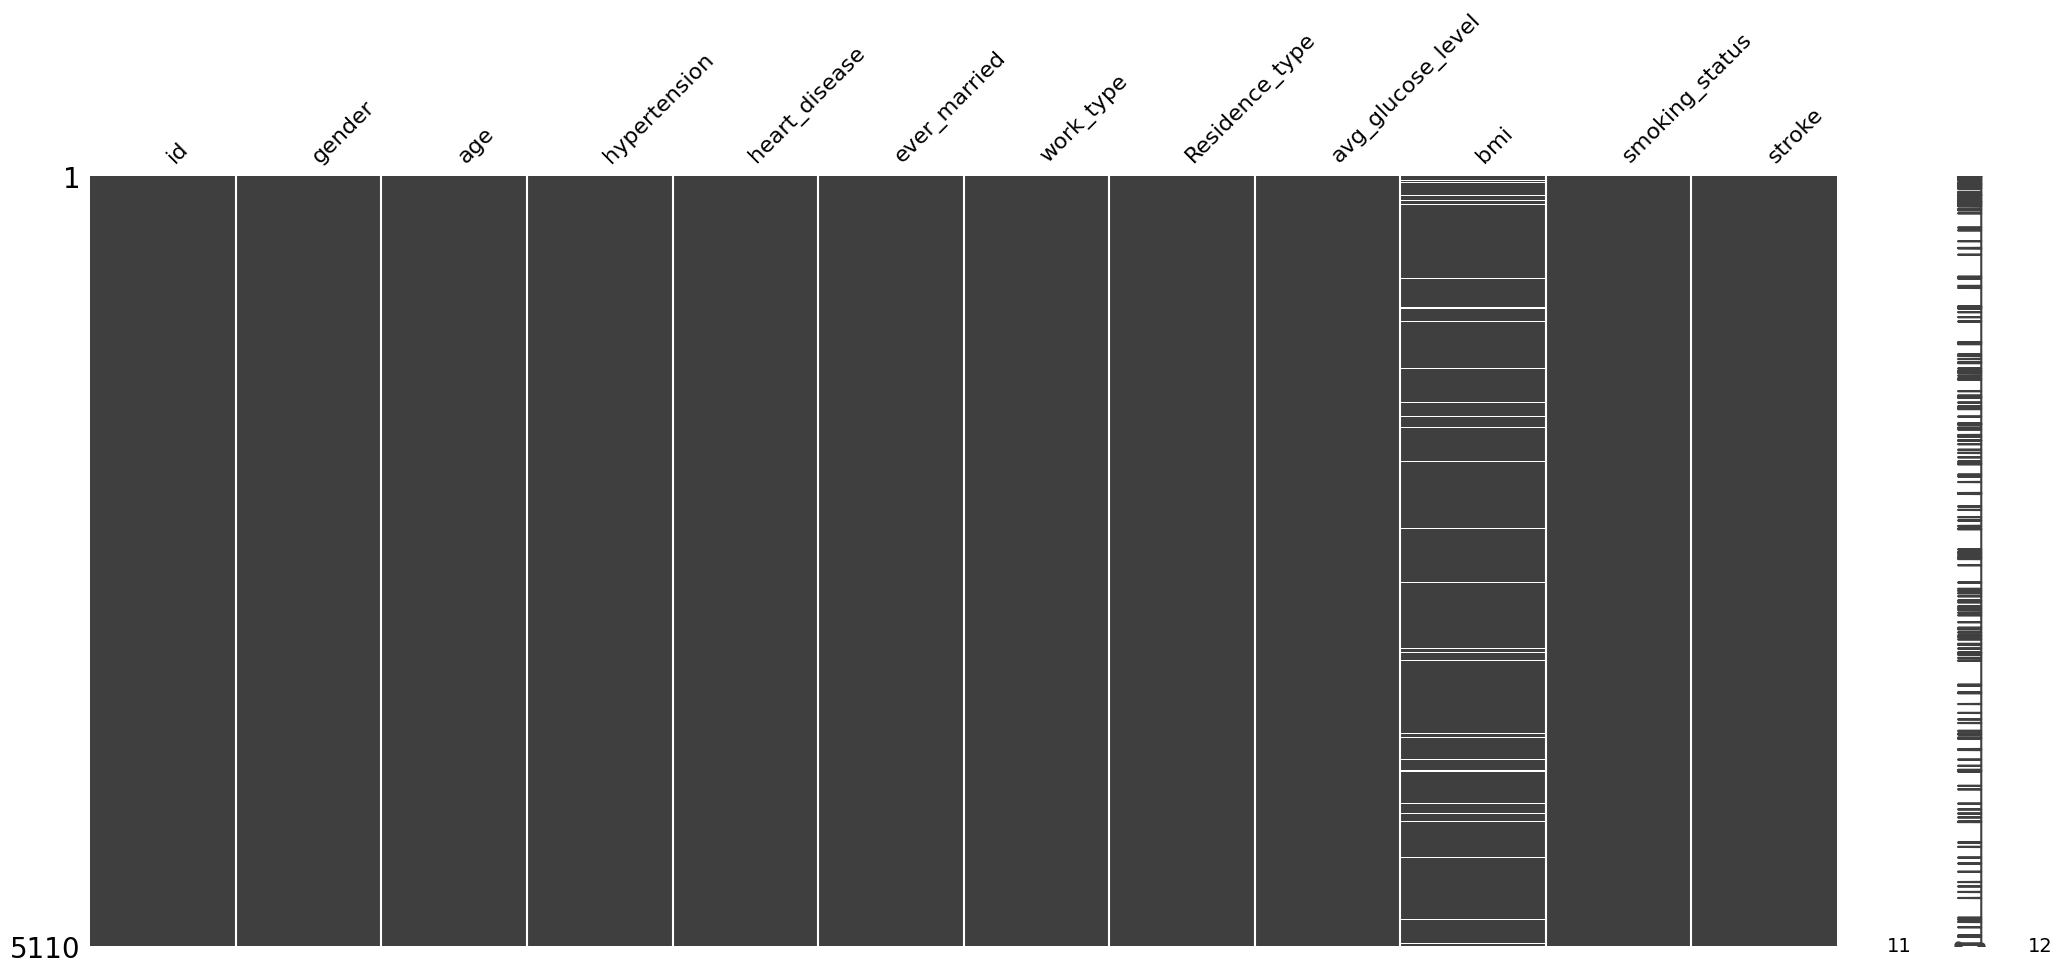

In [55]:
msno.matrix(stroke_df)

In [59]:
stroke_df['id'].value_counts().sum()/len(stroke_df)

1.0

In [61]:
#let's change the index of our data
stroke_df = stroke_df.set_index('id')
stroke_df.head()

gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
9046     Male  67.0             0              1          Yes        Private   
51676  Female  61.0             0              0          Yes  Self-employed   
31112    Male  80.0             0              1          Yes        Private   
60182  Female  49.0             0              0          Yes        Private   
1665   Female  79.0             1              0          Yes  Self-employed   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
9046           Urban             228.69  36.6  formerly smoked       1  
51676          Rural             202.21   NaN     never smoked       1  
31112          Rural             105.92  32.5     never smoked       1  
60182          Urban             171.23  34.4           smokes       1  
1665           Rural             174.12  24.0     never smoked       1

##Target column

In [63]:
target1 = 'stroke'
stroke_df[target1].value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

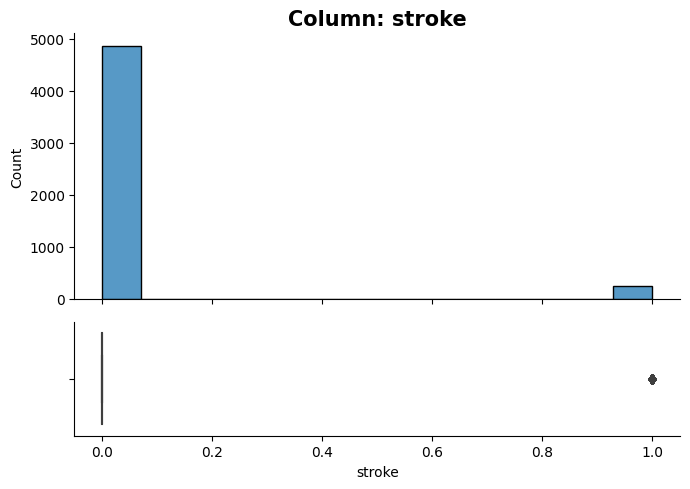

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is 0 , occurs 4861 times (95.13%)
stroke: is neither constant or a quasi-constant feauture and should be kept


In [65]:
explore_num(stroke_df,target1,figsize=(7,5));

In [66]:
stroke_df.select_dtypes('object').columns

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

##gender column

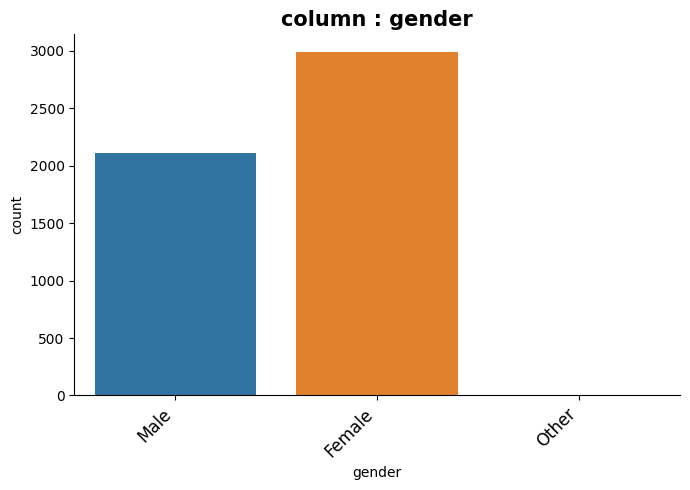

There is 0 NaN (0.0%)
There is 3 unique values
The most common value is Female , occurs 2994 times (58.59%)
gender: is neither constant or a quasi-constant feauture and should be kept


In [67]:
explore_cat(stroke_df,'gender');

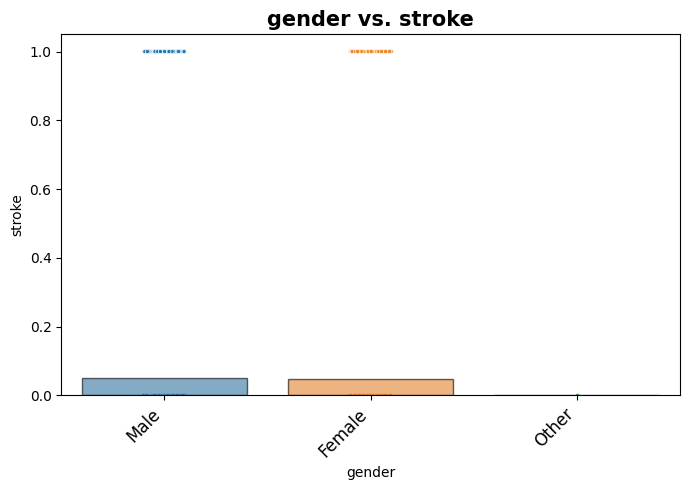

In [68]:
plot_cat_vs_target(stroke_df,'gender',y=target1);

##ever_married column

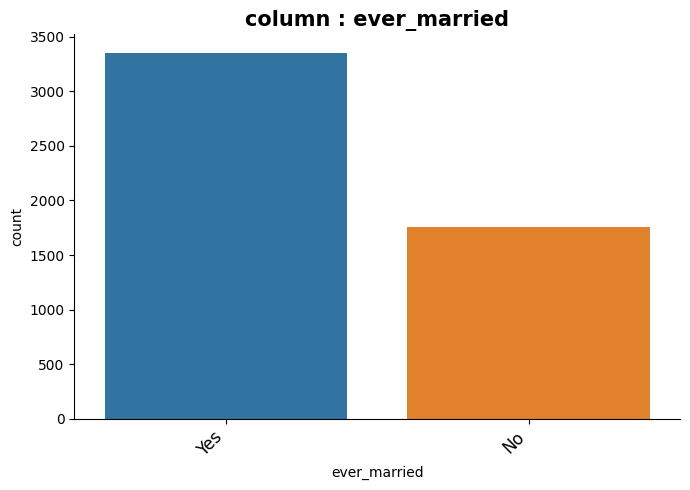

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is Yes , occurs 3353 times (65.62%)
ever_married: is neither constant or a quasi-constant feauture and should be kept


In [69]:
explore_cat(stroke_df,'ever_married');

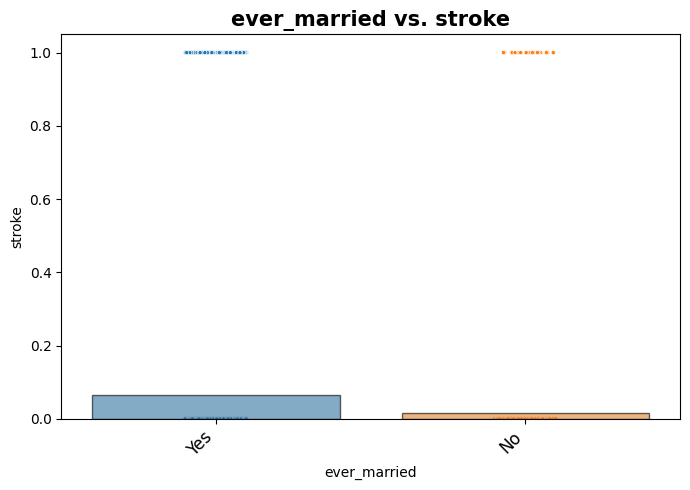

In [70]:
plot_cat_vs_target(stroke_df,'ever_married',y=target1);

##work_type column

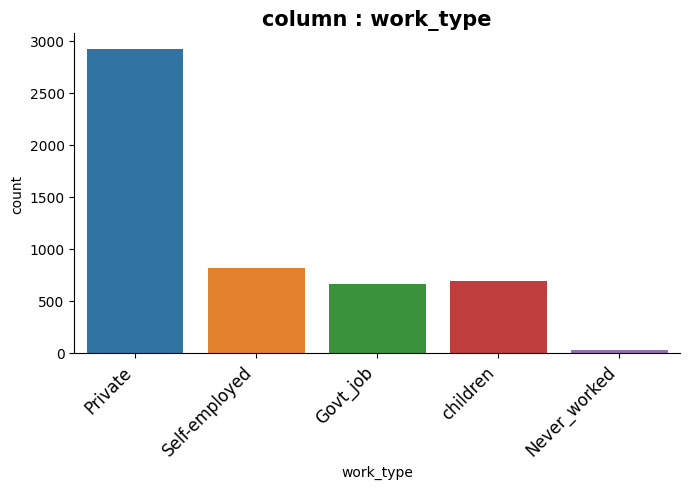

There is 0 NaN (0.0%)
There is 5 unique values
The most common value is Private , occurs 2925 times (57.24%)
work_type: is neither constant or a quasi-constant feauture and should be kept


In [71]:
explore_cat(stroke_df,'work_type');

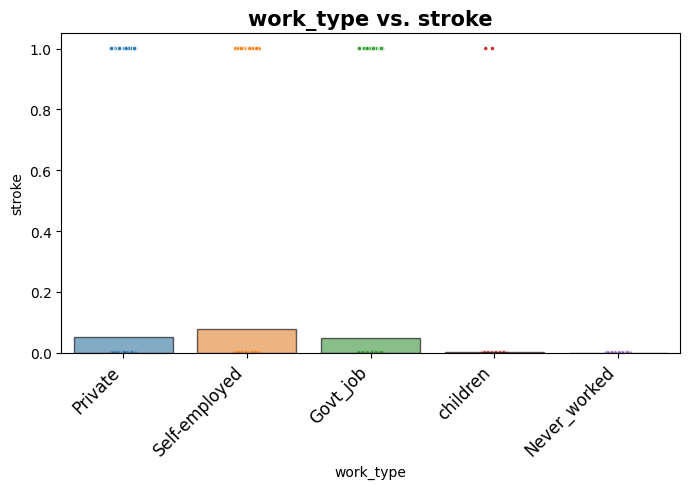

In [72]:
plot_cat_vs_target(stroke_df,'work_type',y=target1);

##Residence_type column

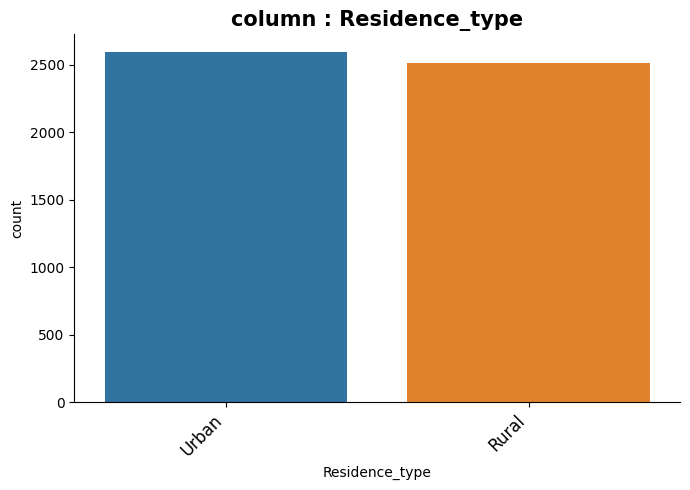

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is Urban , occurs 2596 times (50.8%)
Residence_type: is neither constant or a quasi-constant feauture and should be kept


In [73]:
explore_cat(stroke_df,'Residence_type');

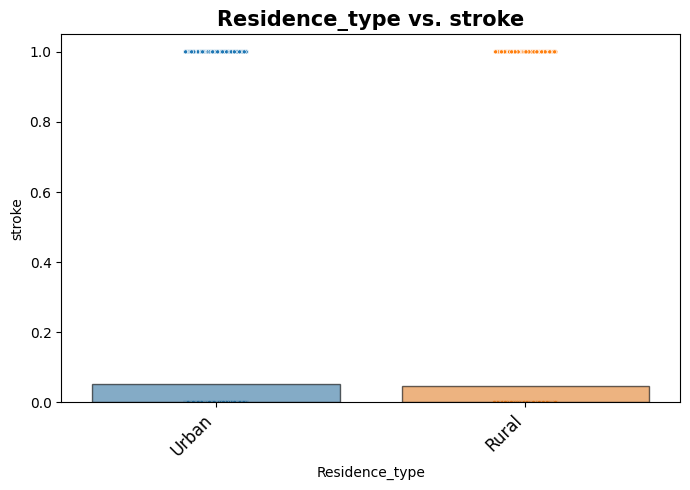

In [74]:
plot_cat_vs_target(stroke_df,'Residence_type',y=target1);

##smoking_status column

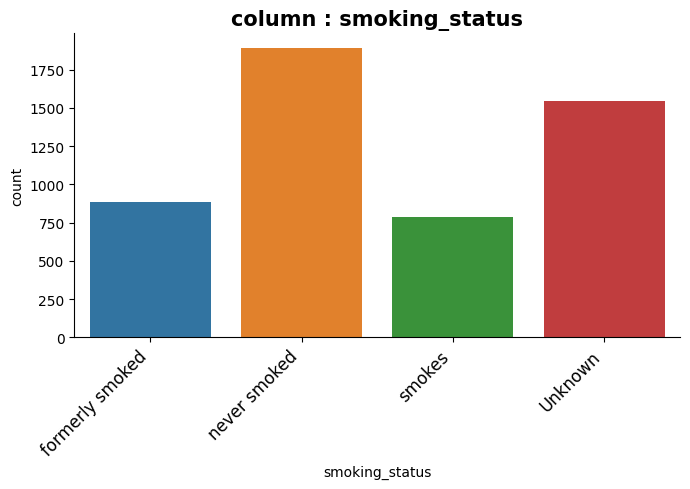

There is 0 NaN (0.0%)
There is 4 unique values
The most common value is never smoked , occurs 1892 times (37.03%)
smoking_status: is neither constant or a quasi-constant feauture and should be kept


In [75]:
explore_cat(stroke_df,'smoking_status');

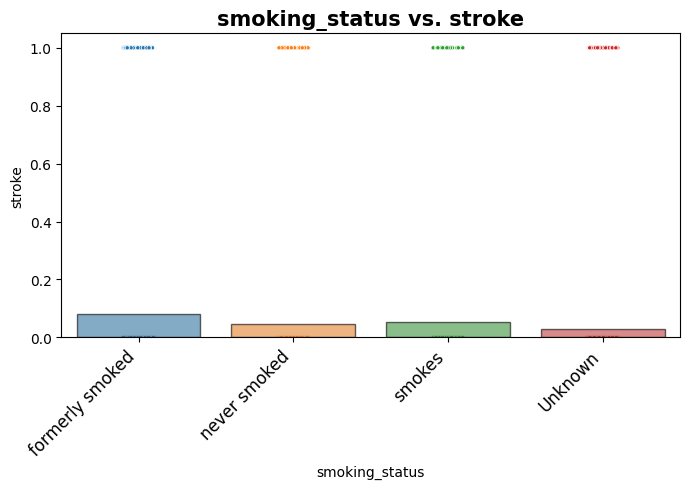

In [76]:
plot_cat_vs_target(stroke_df,'smoking_status',y=target1);

In [77]:
stroke_df.select_dtypes('number').columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke'],
      dtype='object')

##age column

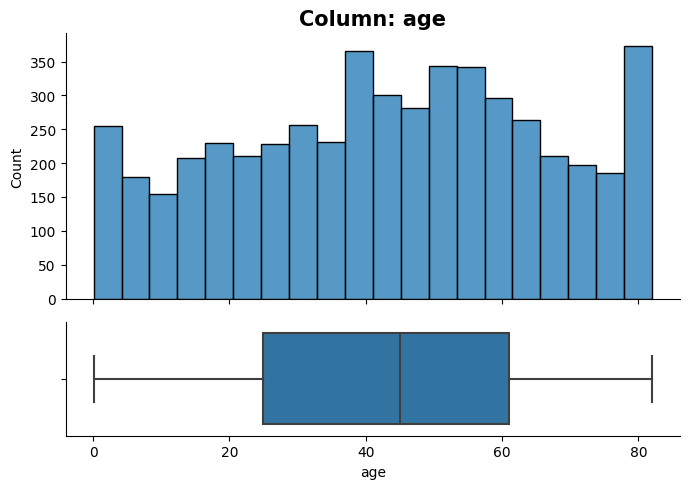

There is 0 NaN (0.0%)
There is 104 unique values
The most common value is 78.0 , occurs 102 times (2.0%)
age: is neither constant or a quasi-constant feauture and should be kept


In [78]:
explore_num(stroke_df,'age',figsize=(7,5));

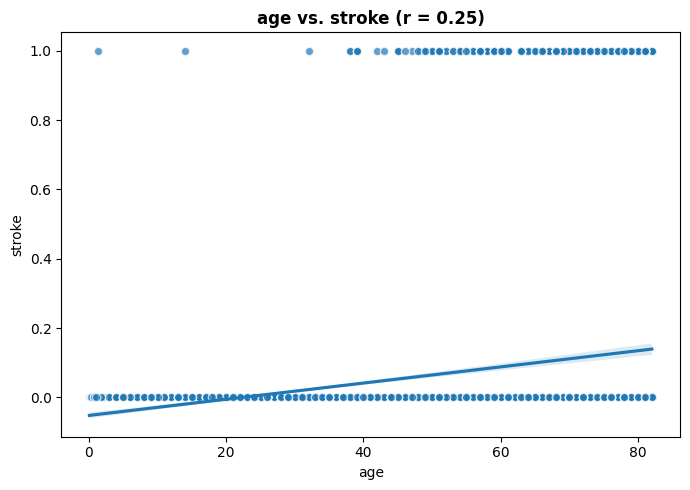

In [79]:
plot_num_vs_target(stroke_df,'age',y=target1);

##hypertension column

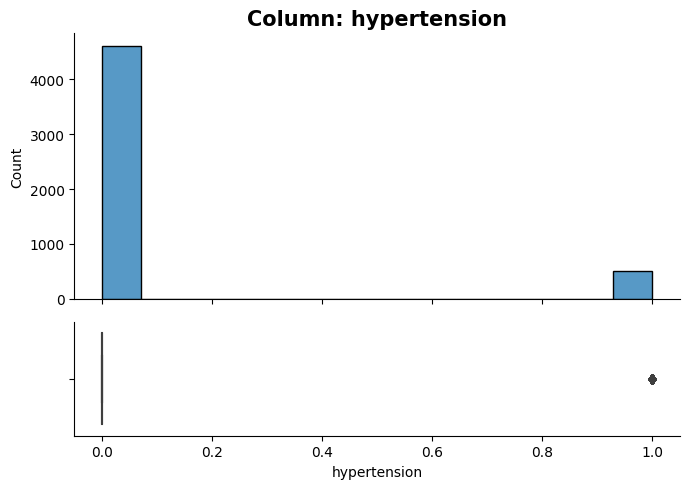

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is 0 , occurs 4612 times (90.25%)
hypertension: is neither constant or a quasi-constant feauture and should be kept


In [80]:
explore_num(stroke_df,'hypertension',figsize=(7,5));

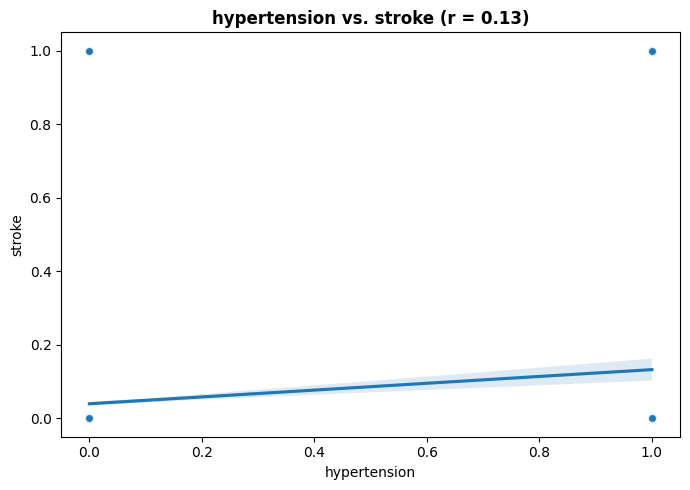

In [81]:
plot_num_vs_target(stroke_df,'hypertension',y=target1);

##heart_disease column

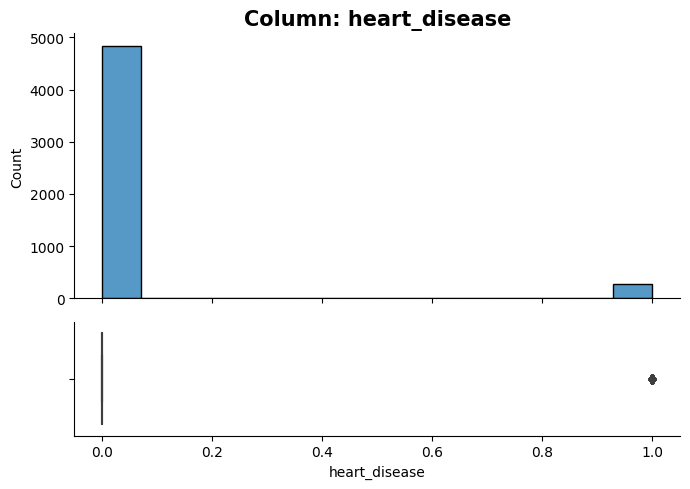

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is 0 , occurs 4834 times (94.6%)
heart_disease: is neither constant or a quasi-constant feauture and should be kept


In [82]:
explore_num(stroke_df,'heart_disease',figsize=(7,5));

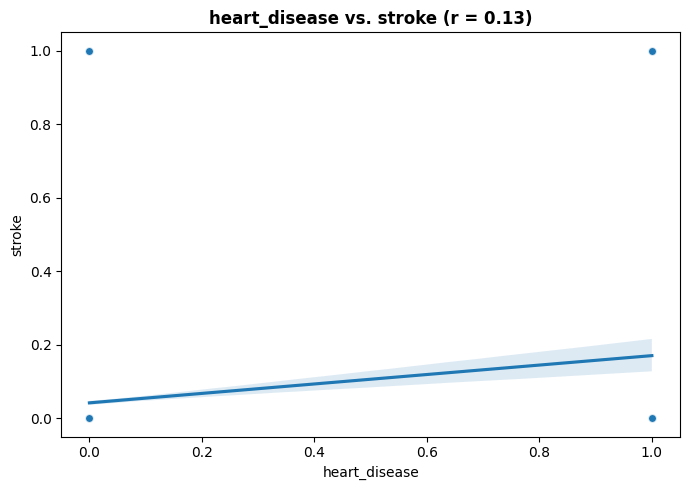

In [83]:
plot_num_vs_target(stroke_df,'heart_disease',y=target1);

##avg_glucose_level column

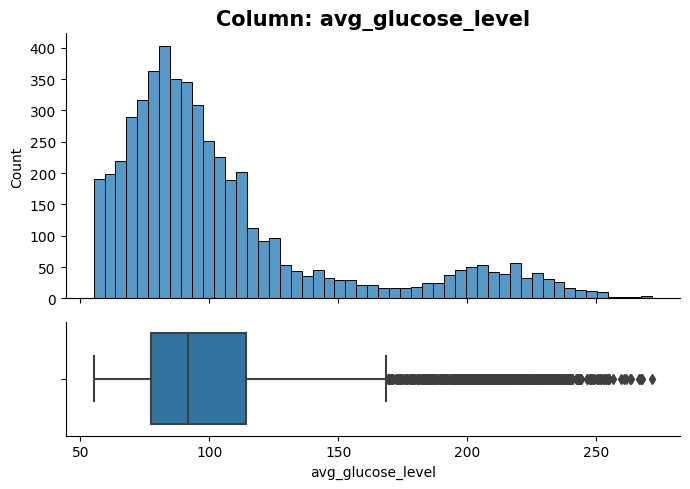

There is 0 NaN (0.0%)
There is 3979 unique values
The most common value is 93.88 , occurs 6 times (0.12%)
avg_glucose_level: is neither constant or a quasi-constant feauture and should be kept


In [84]:
explore_num(stroke_df,'avg_glucose_level',figsize=(7,5));

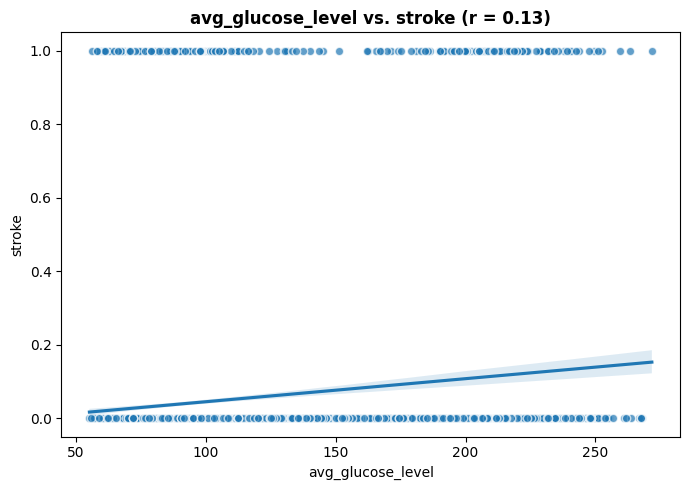

In [85]:
plot_num_vs_target(stroke_df,'avg_glucose_level',y=target1);

##bmi column

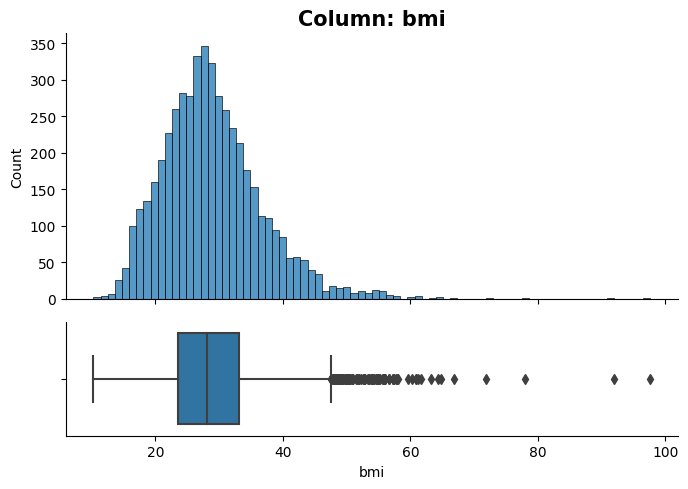

There is 201 NaN (3.93%)
There is 418 unique values
The most common value is nan , occurs 201 times (3.93%)
bmi: is neither constant or a quasi-constant feauture and should be kept


In [86]:
explore_num(stroke_df,'bmi',figsize=(7,5));

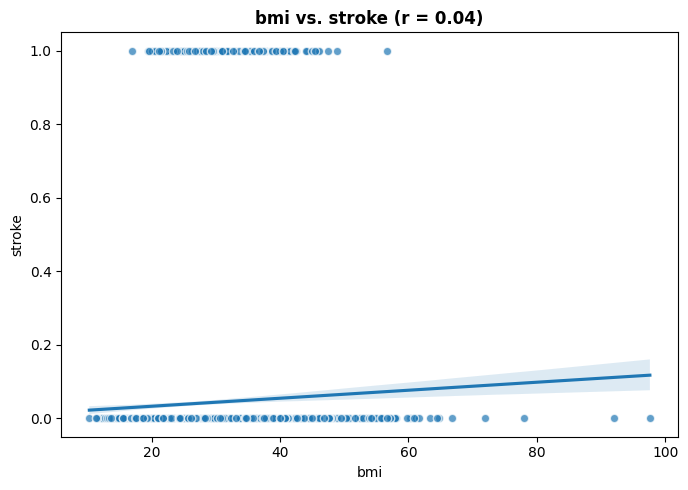

In [87]:
plot_num_vs_target(stroke_df,'bmi',y=target1);

bmi is a numerical feature and it has missing values , so for the imputation i will use the median strategy.

<ipython-input-88-cc10ffe11211>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = stroke_df.corr()


<Axes: >

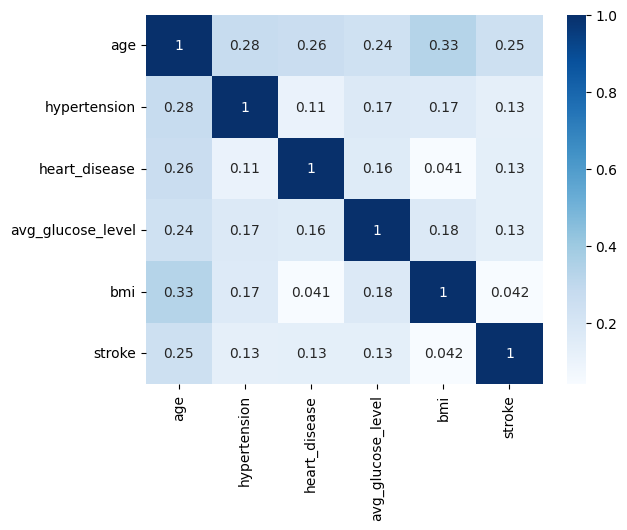

In [88]:
cor = stroke_df.corr()
sns.heatmap(cor, cmap = 'Blues' , annot=True)

In [89]:
stroke_df.describe().round(2)

age  hypertension  heart_disease  avg_glucose_level      bmi  \
count  5110.00        5110.0        5110.00            5110.00  4909.00   
mean     43.23           0.1           0.05             106.15    28.89   
std      22.61           0.3           0.23              45.28     7.85   
min       0.08           0.0           0.00              55.12    10.30   
25%      25.00           0.0           0.00              77.24    23.50   
50%      45.00           0.0           0.00              91.88    28.10   
75%      61.00           0.0           0.00             114.09    33.10   
max      82.00           1.0           1.00             271.74    97.60   

        stroke  
count  5110.00  
mean      0.05  
std       0.22  
min       0.00  
25%       0.00  
50%       0.00  
75%       0.00  
max       1.00